# Setup

### Load libraries

In [2]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import jinja2
import matplotlib.pyplot as plt
from weasyprint import HTML as WPHTML
from weasyprint import CSS
from html2image import Html2Image
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.width")
pd.set_option('display.max_colwidth', 100)

### Load data

In [3]:
root_dirs = [
    "experiments/some_models_all_ex_defs_context",
    "experiments/grok_mini_defs_context",
    "experiments/gemini_thinking_defs_context"
]

data_list = []

for root_dir in root_dirs:
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(subdir, file)
                try:
                    with open(json_path, 'r') as f:
                        data = json.load(f)
                    
                    # Extract experiment name: first part after "experiments/"
                    experiment_name = os.path.normpath(subdir).split(os.sep)
                    experiment_idx = experiment_name.index("experiments") + 1
                    experiment = experiment_name[experiment_idx]
                    
                    # Extract timestamp: immediate parent folder of JSON file
                    timestamp = os.path.basename(subdir)
                    
                    # Add to data
                    data["experiment"] = experiment
                    data["timestamp"] = timestamp
                    
                    data_list.append(data)
                except json.JSONDecodeError:
                    print(f"Failed to decode JSON: {json_path}")

# Create DataFrame
df = pd.DataFrame(data_list)

# Optional: filter out unwanted models
exclude_models = ['openai/o4-mini-high', 'openai/gpt-4o-mini']
df = df[~df['model'].isin(exclude_models)]


# Drop Grok Mini models from 'some_models_all_ex_defs_context' experiment
df = df[~(
    (df['experiment'] == 'some_models_all_ex_defs_context') &
    (df['model'].str.contains("x-ai/grok-3-mini-beta"))
)]

# Drop Gemini:thinking models from 'some_models_all_ex_defs_context' experiment
df = df[~(
    (df['experiment'] == 'some_models_all_ex_defs_context') &
    (df['model'].str.contains("google/gemini-2.5-flash-preview-05-20:thinking"))
)]

# Define a composite run identifier
df['full_run_id'] = df['experiment'] + ' | ' + df['timestamp'] + ' | ' + df['run_id']

len(df)


4463

# Case-by-case data analysis

### Inspect example data entry

In [4]:
pd.set_option('display.max_colwidth', 100)
df.iloc[0].to_frame()

,0
model,x-ai/grok-3-beta
exercise,10_7_6
prompt,"You are asked to write a proof in the syntax of Waterproof, a theorem proving educational softwa..."
tutorial,# Waterproof Tutorial\n\n## 1. We conclude that\n\n### Example:\n\nLemma example_reflexivity :\n...
full_input,"Your proof seems to have some mistakes in it, as it does not compile correctly.\nHere is the err..."
exercise_content,"Section colors.\nVariable P : ℕ → Color.\n\nParameter infinitely_many_blues :\n ∀ K ∈ ℕ, ∃ m ≥ ..."
output,"Proof.\nWe need to show that (∃ n : (ℕ → ℕ), (is_index_sequence n) ∧ (∀ k ∈ ℕ, P(n(k)) = blue))...."
token_count,5539
input_tokens,5158
thinking_tokens,0


### See number of runs per model

In [5]:
# Count number of unique runs per model
runs_per_model = df[['model', 'full_run_id']].drop_duplicates().groupby('model').size().reset_index(name='num_runs')

# Optional: sort by num_runs descending
runs_per_model = runs_per_model.sort_values(by='num_runs', ascending=False)

# Display
runs_per_model

,model,num_runs
0,anthropic/claude-sonnet-4,27
1,google/gemini-2.5-flash-preview-05-20,27
2,google/gemini-2.5-flash-preview-05-20:thinking,27
3,openai/gpt-4.1,27
4,openai/o4-mini,27
5,x-ai/grok-3-beta,27
6,x-ai/grok-3-mini-beta,27


### Inspect runs per model

In [6]:
model_to_inspect = 'anthropic/claude-sonnet-4'

# Filter to the model of interest
df_model = df[df['model'] == model_to_inspect].copy()

# Get unique runs
unique_full_run_ids = df_model['full_run_id'].unique()

print(f"Number of unique runs for model '{model_to_inspect}': {len(unique_full_run_ids)}")

# Optionally show the run IDs for inspection
for i, run in enumerate(unique_full_run_ids):
    print(f"{i}: {run}")


Number of unique runs for model 'anthropic/claude-sonnet-4': 27
0: some_models_all_ex_defs_context | 2025-06-10_03-10-52 | anthropic/claude-sonnet-4::10_7_6::1
1: some_models_all_ex_defs_context | 2025-06-10_03-09-21 | anthropic/claude-sonnet-4::10_7_intermediate::1
2: some_models_all_ex_defs_context | 2025-06-10_03-10-27 | anthropic/claude-sonnet-4::10_7_3::1
3: some_models_all_ex_defs_context | 2025-06-10_00-12-06 | anthropic/claude-sonnet-4::2_reflexive_2::1
4: some_models_all_ex_defs_context | 2025-06-10_00-12-06 | anthropic/claude-sonnet-4::2_triangle_inequality_2::1
5: some_models_all_ex_defs_context | 2025-06-10_00-12-06 | anthropic/claude-sonnet-4::2_positive_2::1
6: some_models_all_ex_defs_context | 2025-06-10_00-12-06 | anthropic/claude-sonnet-4::4_9_2::1
7: some_models_all_ex_defs_context | 2025-06-10_00-12-06 | anthropic/claude-sonnet-4::5_9_1::1
8: some_models_all_ex_defs_context | 2025-06-10_00-12-06 | anthropic/claude-sonnet-4::2_triangle_inequality_1::1
9: some_models_a

### Inspect errors in a particular run

In [53]:
# Select the Nth run (e.g. first one)
run_index = 9 # change this to pick different run
selected_full_run_id = unique_full_run_ids[run_index]

# Filter rows corresponding to this run
df_run = df_model[df_model['full_run_id'] == selected_full_run_id].sort_values(by='attempt').copy()

# Clean up error message
df_run['error_message'] = df_run['errors'].apply(
    lambda x: x.split('\n', 1)[1] if isinstance(x, str) and '\n' in x else ''
)

# Show trace table
df_run[['model', 'exercise', 'attempt', 'error_message', 'line_with_error']]


,model,exercise,attempt,error_message,line_with_error
1465,anthropic/claude-sonnet-4,2_reflexive_1,1,"Error:\n(d(x, x) = dist_Y(f(x), f(x))) does not correspond to what you need to show.\n\n","By (definition_d) we conclude that (d(x, x) = dist_Y(f(x), f(x)))."
1651,anthropic/claude-sonnet-4,2_reflexive_1,2,"Error: (dist_Y(f(x), f(x)) = 0) does not correspond to what you need to show.\n\n","We conclude that (dist_Y(f(x), f(x)) = 0)."
463,anthropic/claude-sonnet-4,2_reflexive_1,3,"Error: Could not verify that (dist_Y(f(x), f(x)) = 0).\n\n","We conclude that (dist_Y(f(x), f(x)) = 0)."
1927,anthropic/claude-sonnet-4,2_reflexive_1,4,Error:\nSyntax error: 'it' or 'we' 'conclude' expected after [constr] (in [ltac2_expr]).\n\n,"Since (f(x) ∈ Y), we conclude that (dist_Y(f(x), f(x)) = 0)."
1864,anthropic/claude-sonnet-4,2_reflexive_1,5,"Error: Could not verify that (dist_Y(f(x), f(x)) = 0).\n\n","We conclude that (dist_Y(f(x), f(x)) = 0)."
1885,anthropic/claude-sonnet-4,2_reflexive_1,6,Error: Wrong goal specified.\n\n,"We need to show that (dist_Y(f(x), f(x)) = 0)."
1901,anthropic/claude-sonnet-4,2_reflexive_1,7,"Error: Could not verify that (d(x, x) = 0).\n\n","We conclude that (d(x, x) = 0)."
2006,anthropic/claude-sonnet-4,2_reflexive_1,8,"Error:\n(d(x, x) = dist_Y(f(x), f(x))) does not correspond to what you need to show.\n\n","By (definition_d) we conclude that (d(x, x) = dist_Y(f(x), f(x)))."
776,anthropic/claude-sonnet-4,2_reflexive_1,9,Error: Wrong goal specified.\n\n,"We need to show that (dist_Y(f(x), f(x)) = 0)."
2349,anthropic/claude-sonnet-4,2_reflexive_1,10,"Error: Could not verify that (d(x, x) = 0).\n\n","We conclude that (d(x, x) = 0)."


### Display diff between proof revisions

In [8]:
from IPython.display import display, HTML
import difflib
import html

def show_proof_diff(df_run, attempt_number_1, attempt_number_2):
    # Extract proofs
    proof_1 = df_run[df_run['attempt'] == attempt_number_1]['output'].iloc[0]
    proof_2 = df_run[df_run['attempt'] == attempt_number_2]['output'].iloc[0]

    # Extract additional info
    error_1 = df_run[df_run['attempt'] == attempt_number_1]['errors'].iloc[0]
    error_2 = df_run[df_run['attempt'] == attempt_number_2]['errors'].iloc[0]

    line_with_error_1 = df_run[df_run['attempt'] == attempt_number_1]['line_with_error'].iloc[0]
    line_with_error_2 = df_run[df_run['attempt'] == attempt_number_2]['line_with_error'].iloc[0]

    # Escape additional info
    escaped_error_1 = html.escape(error_1.split('Error:', 1)[1].strip()) if isinstance(error_1, str) and 'Error:' in error_1 else html.escape(error_1) if isinstance(error_1, str) else ''
    escaped_error_2 = html.escape(error_2.split('Error:', 1)[1].strip()) if isinstance(error_2, str) and 'Error:' in error_2 else html.escape(error_2) if isinstance(error_2, str) else ''

    escaped_line_with_error_1 = html.escape(line_with_error_1) if isinstance(line_with_error_1, str) else ''
    escaped_line_with_error_2 = html.escape(line_with_error_2) if isinstance(line_with_error_2, str) else ''

    # Split into lines and compute diff
    proof_1_lines = proof_1.splitlines()
    proof_2_lines = proof_2.splitlines()

    diff = list(difflib.ndiff(proof_1_lines, proof_2_lines))

    # Process diff for left and right columns
    left_col = []
    right_col = []

    for line in diff:
        tag = line[:2]
        content = html.escape(line[2:])  # escape <, >, &, etc.

        if tag == '  ':
            left_col.append(f"<div>{content}</div>")
            right_col.append(f"<div>{content}</div>")
        elif tag == '- ':
            left_col.append(f"<div style='background-color:#441111;'>{content}</div>")
            right_col.append(f"<div style='background-color:#222222;'></div>")
        elif tag == '+ ':
            left_col.append(f"<div style='background-color:#222222;'></div>")
            right_col.append(f"<div style='background-color:#114411;'>{content}</div>")
        elif tag == '? ':
            # ignore helper lines like ^^^^^^ in diffs
            continue

    # Combine columns into HTML → vertical layout
    html_table = f"""
    <div style="font-family: monospace; background-color: #1e1e1e; color: white; padding: 10px;">
        <div style="padding-bottom: 20px;">
            <div style="font-weight: bold; padding-bottom: 5px;">Attempt {attempt_number_1}</div>
            {''.join(left_col)}
            <div style="padding-top: 10px; color: #aaaaaa;">
                <div><b>Error:</b> {escaped_error_1}</div>
                <div><b>Line with error:</b> {escaped_line_with_error_1}</div>
            </div>
        </div>
        <div>
            <div style="font-weight: bold; padding-bottom: 5px;">Attempt {attempt_number_2}</div>
            {''.join(right_col)}
            <div style="padding-top: 10px; color: #aaaaaa;">
                <div><b>Error:</b> {escaped_error_2}</div>
                <div><b>Line with error:</b> {escaped_line_with_error_2}</div>
            </div>
        </div>
    </div>
    """

    display(HTML(html_table))


In [58]:
show_proof_diff(df_run, 5, 6)

### Total cost estimation

In [123]:
total_cost = df['cost'].sum()
total_cost

np.float64(5.3984893)

# Aggregate data analysis

### Success rate per model

In [255]:
# Group by model and run, compute per-run success (1 if any attempt succeeded)
per_run_success = df.groupby(['model', 'full_run_id'])['success'].max().reset_index()

# Aggregate per model: success_rate, total_runs, successful_runs
agg_success_rate = per_run_success.groupby('model')['success'].agg(['mean', 'count', 'sum']).reset_index()

# Rename columns for clarity
agg_success_rate.rename(columns={
    'mean': 'success_rate',
    'count': 'total_runs',
    'sum': 'successful_runs'
}, inplace=True)

# Convert success_rate to % for display
agg_success_rate['success_rate'] = agg_success_rate['success_rate'] * 100

# Optional: round to 1 decimal place
agg_success_rate['success_rate'] = agg_success_rate['success_rate'].round(1)

# Reorder columns: successful_runs, total_runs, success_rate, sort by success_rate descending
agg_success_rate = agg_success_rate[['model', 'successful_runs', 'total_runs', 'success_rate']].sort_values(by='success_rate', ascending=False)

# Display the table
agg_success_rate

,model,successful_runs,total_runs,success_rate
0,anthropic/claude-sonnet-4,12,27,44.4
2,google/gemini-2.5-flash-preview-05-20:thinking,10,27,37.0
4,openai/o4-mini,10,27,37.0
3,openai/gpt-4.1,9,27,33.3
5,x-ai/grok-3-beta,7,27,25.9
6,x-ai/grok-3-mini-beta,7,27,25.9
1,google/gemini-2.5-flash-preview-05-20,6,27,22.2


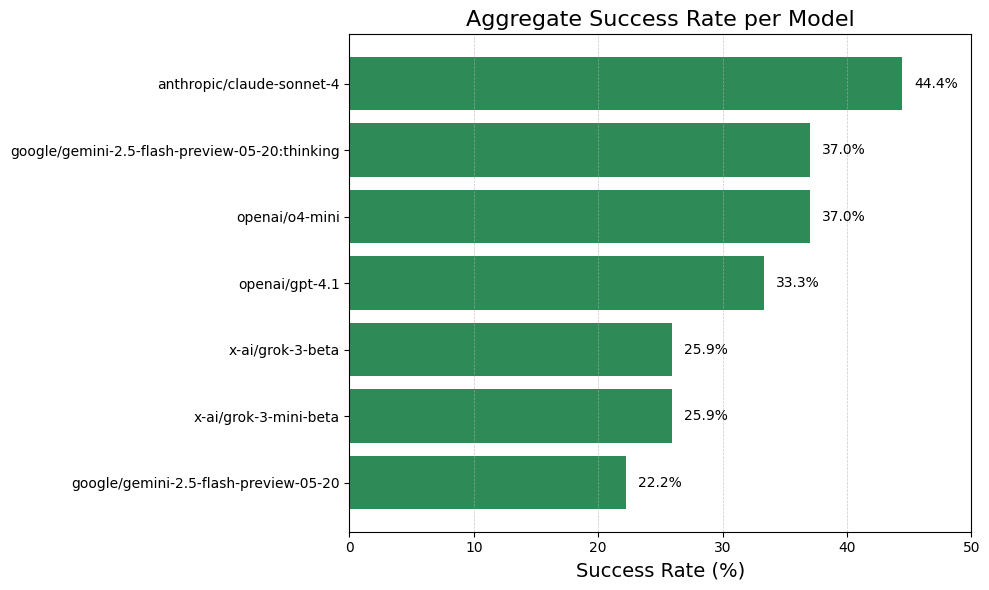

In [256]:
# Plot success_rate per model
plt.figure(figsize=(10, 6))

plt.barh(
    agg_success_rate['model'],
    agg_success_rate['success_rate'],
    color='seagreen'
)

# Invert y-axis so best model is at the top
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel('Success Rate (%)', fontsize=14)
plt.xlim(0,50)
plt.title('Aggregate Success Rate per Model', fontsize=16)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

# Annotate bars with success rate
for i, v in enumerate(agg_success_rate['success_rate']):
    plt.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('visualization/success_rate_models.pdf', bbox_inches='tight')
plt.show()

### Success rate per exercise

In [257]:
# Group by exercise and run, compute per-run success
per_run_success_ex = df.groupby(['exercise', 'full_run_id'])['success'].max().reset_index()

# Aggregate per exercise
agg_success_rate_ex = per_run_success_ex.groupby('exercise')['success'].agg(['mean', 'count', 'sum']).reset_index()

# Rename columns for clarity
agg_success_rate_ex.rename(columns={
    'mean': 'success_rate',
    'count': 'total_runs',
    'sum': 'successful_runs'
}, inplace=True)

# Convert success_rate to % and round
agg_success_rate_ex['success_rate'] = agg_success_rate_ex['success_rate'] * 100
agg_success_rate_ex['success_rate'] = agg_success_rate_ex['success_rate'].round(1)

# Reorder columns: successful_runs, total_runs, success_rate, sort by success_rate descending
agg_success_rate_ex = agg_success_rate_ex[['exercise', 'successful_runs', 'total_runs', 'success_rate']].sort_values(by='success_rate', ascending=False)

# Display the table
agg_success_rate_ex


,exercise,successful_runs,total_runs,success_rate
2,10_7_intermediate,7,7,100.0
8,2_non_degenerate_2,7,7,100.0
12,2_reflexive_2,7,7,100.0
17,3_11_1,7,7,100.0
18,3_11_2,6,7,85.7
10,2_positive_2,6,7,85.7
20,4_9_1,5,7,71.4
21,4_9_2,4,7,57.1
19,3_11_4,3,7,42.9
6,13_11_3,2,7,28.6


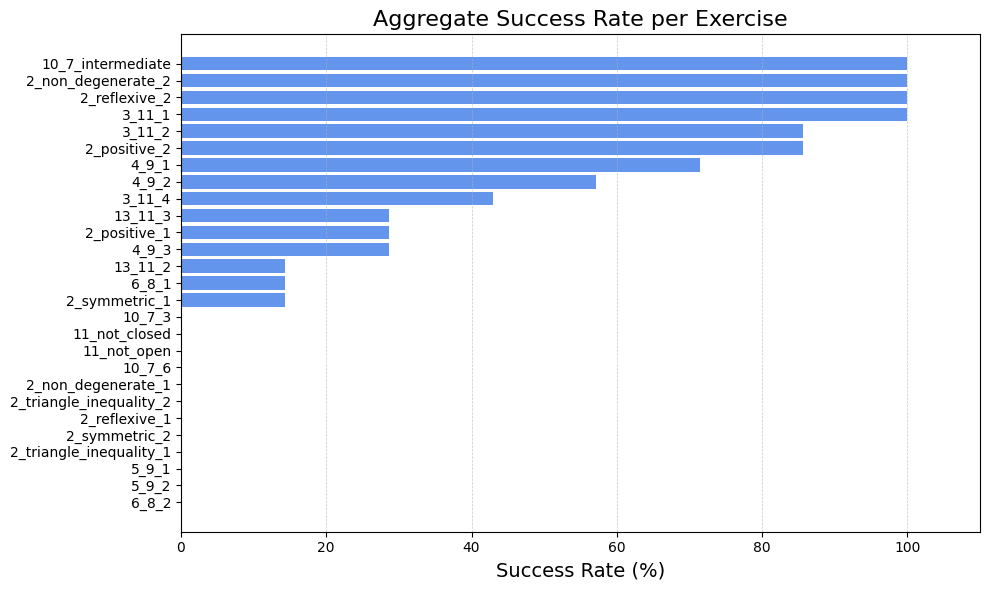

In [258]:
# Plot success_rate per exercise
plt.figure(figsize=(10, 6))

plt.barh(
    agg_success_rate_ex['exercise'],
    agg_success_rate_ex['success_rate'],
    color='cornflowerblue'
)

# Invert y-axis so best exercises appear at the top
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel('Success Rate (%)', fontsize=14)
plt.xlim(0,110)
plt.title('Aggregate Success Rate per Exercise', fontsize=16)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

# Annotate bars with success rate
#for i, v in enumerate(agg_success_rate_ex['success_rate']):
#    plt.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('visualization/success_rate_exercises.pdf', bbox_inches='tight')
plt.show()


### Success rate per model and exercise

In [259]:
# Group by model, exercise, run — compute per-run success
per_run_success_grid = df.groupby(['model', 'exercise', 'full_run_id'])['success'].max().reset_index()

# Now pivot: model as rows, exercise as columns, value = mean per run (in %)
grid = per_run_success_grid.pivot_table(
    index='model',
    columns='exercise',
    values='success',
    aggfunc='mean'
) * 100

# Round nicely
grid = grid.round(1)

# Display the grid
grid


exercise,10_7_3,10_7_6,10_7_intermediate,11_not_closed,11_not_open,13_11_2,13_11_3,2_non_degenerate_1,2_non_degenerate_2,2_positive_1,...,3_11_1,3_11_2,3_11_4,4_9_1,4_9_2,4_9_3,5_9_1,5_9_2,6_8_1,6_8_2
model,,,,,,,,,,,,,,,,,,,,,
anthropic/claude-sonnet-4,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,...,100.0,100.0,100.0,100.0,0.0,100.0,0.0,0.0,100.0,0.0
google/gemini-2.5-flash-preview-05-20,0.0,0.0,100.0,0.0,0.0,100.0,0.0,0.0,100.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
google/gemini-2.5-flash-preview-05-20:thinking,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0,0.0,...,100.0,100.0,0.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0
openai/gpt-4.1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,100.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0
openai/o4-mini,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,...,100.0,100.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0
x-ai/grok-3-beta,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,100.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
x-ai/grok-3-mini-beta,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,100.0,100.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0


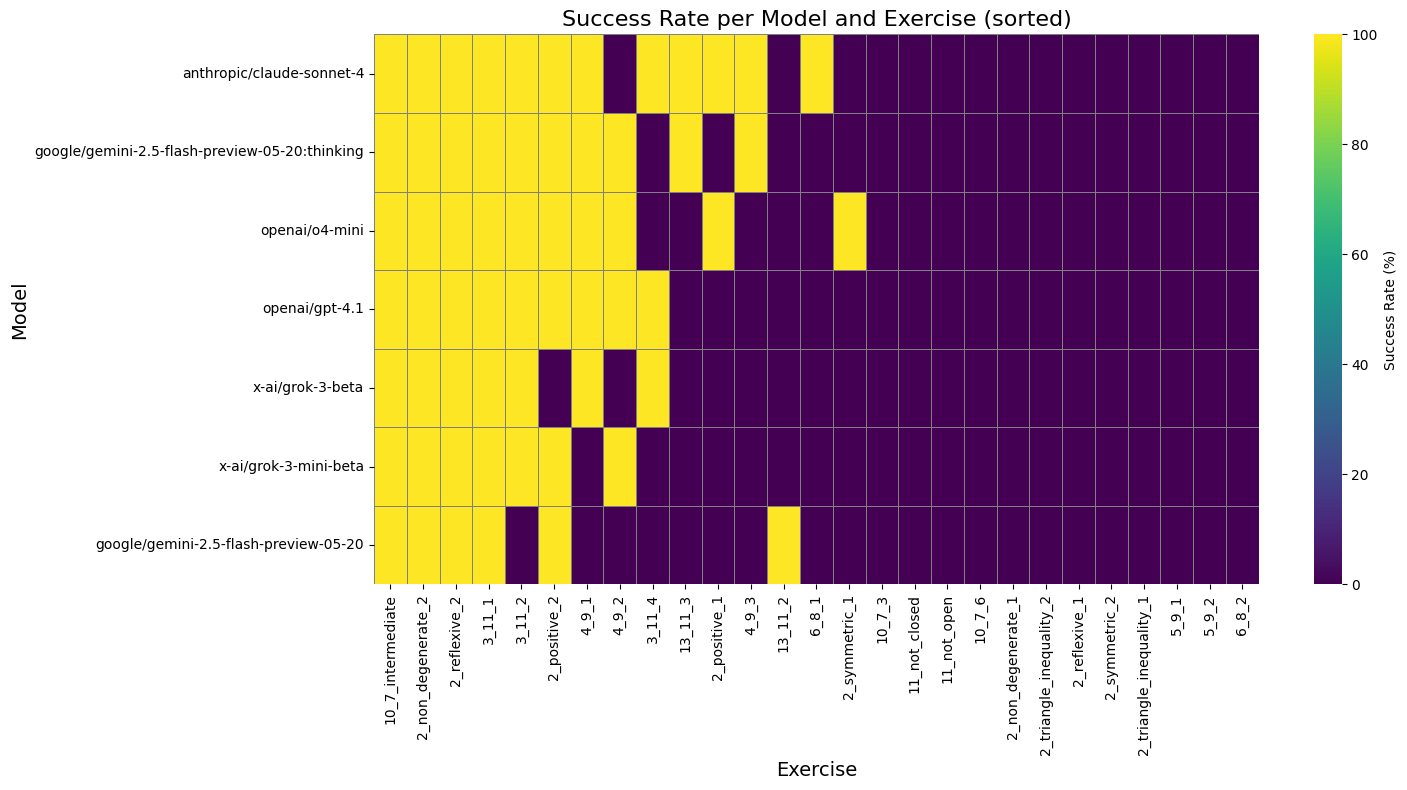

In [260]:
# Compute overall success rate per model and exercise
model_order = grid.mean(axis=1).sort_values(ascending=False).index.tolist()
exercise_order = grid.mean(axis=0).sort_values(ascending=False).index.tolist()

# Plot heatmap
plt.figure(figsize=(15, 8))

sns.heatmap(
    grid.loc[model_order, exercise_order],
    annot=False, fmt='.1f', cmap='viridis', linewidths=0.5, linecolor='gray',
    cbar_kws={'label': 'Success Rate (%)'}
)

# Labels and title
plt.xlabel('Exercise', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.title('Success Rate per Model and Exercise (sorted)', fontsize=16)

plt.tight_layout()
plt.savefig('visualization/success_rate_heatmap.pdf', bbox_inches='tight')
plt.show()


### Average output token counts per model

In [261]:
# Average output token counts per model
output_tokens_avg = df.groupby('model')['output_tokens'].mean().reset_index()
output_tokens_avg.rename(columns={'output_tokens': 'Avg Output Tokens'}, inplace=True)

# Average thinking token counts per model
thinking_tokens_avg = df.groupby('model')['thinking_tokens'].mean().reset_index()
thinking_tokens_avg.rename(columns={'thinking_tokens': 'Avg Thinking Tokens'}, inplace=True)

# Get the thinking_mode per model
thinking_mode_per_model = df[['model', 'thinking_mode']].drop_duplicates()

# Merge into the result
output_tokens_avg = output_tokens_avg.merge(thinking_mode_per_model, on='model')
output_tokens_avg = output_tokens_avg.merge(thinking_tokens_avg, on='model')

output_tokens_avg.sort_values("Avg Thinking Tokens")

,model,Avg Output Tokens,thinking_mode,Avg Thinking Tokens
0,anthropic/claude-sonnet-4,375.567568,False,0.000000
1,google/gemini-2.5-flash-preview-05-20,397.655993,False,0.000000
3,openai/gpt-4.1,348.038622,False,0.000000
5,x-ai/grok-3-beta,272.413333,False,0.000000
6,x-ai/grok-3-mini-beta,534.642780,True,2.292074
4,openai/o4-mini,322.145729,True,3174.623116
2,google/gemini-2.5-flash-preview-05-20:thinking,413.503401,True,8263.646259


### Average cost per model

In [262]:
# Define cost per attempt: group by model → mean cost
cost_per_attempt = df.groupby('model')['cost'].mean().reset_index()

# Rename column for clarity
cost_per_attempt.rename(columns={'cost': 'avg cost per attempt ($)'}, inplace=True)

# Optional: add company column
# cost_per_attempt['company'] = cost_per_attempt['model'].str.split('/').str[0]

# Display the table
cost_per_attempt


,model,avg cost per attempt ($)
0,anthropic/claude-sonnet-4,0.031504
1,google/gemini-2.5-flash-preview-05-20,0.003693
2,google/gemini-2.5-flash-preview-05-20:thinking,0.008848
3,openai/gpt-4.1,0.003345
4,openai/o4-mini,0.022931
5,x-ai/grok-3-beta,0.023582
6,x-ai/grok-3-mini-beta,0.007318


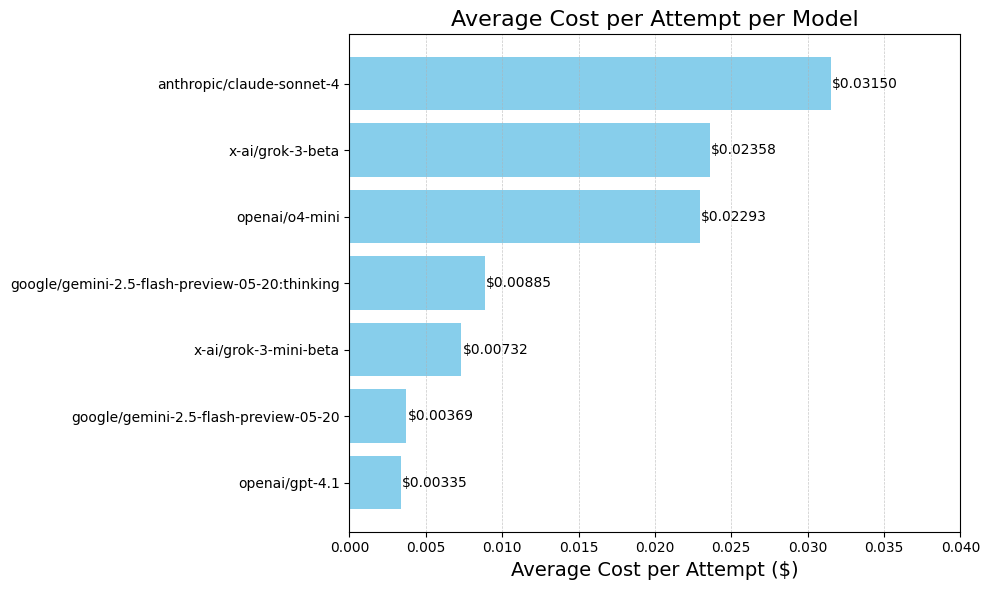

In [263]:
# Sort models by avg cost descending (optional, looks nicer)
cost_per_attempt_sorted = cost_per_attempt.sort_values(by='avg cost per attempt ($)', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(
    cost_per_attempt_sorted['model'],
    cost_per_attempt_sorted['avg cost per attempt ($)'],
    color='skyblue'
)
plt.xlim(0,0.04)

# Labels and title
plt.xlabel('Average Cost per Attempt ($)', fontsize=14)
plt.title('Average Cost per Attempt per Model', fontsize=16)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

# Optional: annotate bars with cost value
for i, v in enumerate(cost_per_attempt_sorted['avg cost per attempt ($)']):
    plt.text(v + 0.0001, i, f'${v:.5f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('visualization/cost_per_model.pdf', bbox_inches='tight')
plt.show()

In [264]:
# Merge success rate and cost dataframes
merged_df = agg_success_rate[['model', 'success_rate']].merge(
    cost_per_attempt[['model', 'avg cost per attempt ($)']],
    on='model'
)

# Sort by success rate (worst to best)
merged_df = merged_df.sort_values(by='success_rate')

# Display merged_df to check
merged_df


,model,success_rate,avg cost per attempt ($)
6,google/gemini-2.5-flash-preview-05-20,22.2,0.003693
4,x-ai/grok-3-beta,25.9,0.023582
5,x-ai/grok-3-mini-beta,25.9,0.007318
3,openai/gpt-4.1,33.3,0.003345
1,google/gemini-2.5-flash-preview-05-20:thinking,37.0,0.008848
2,openai/o4-mini,37.0,0.022931
0,anthropic/claude-sonnet-4,44.4,0.031504


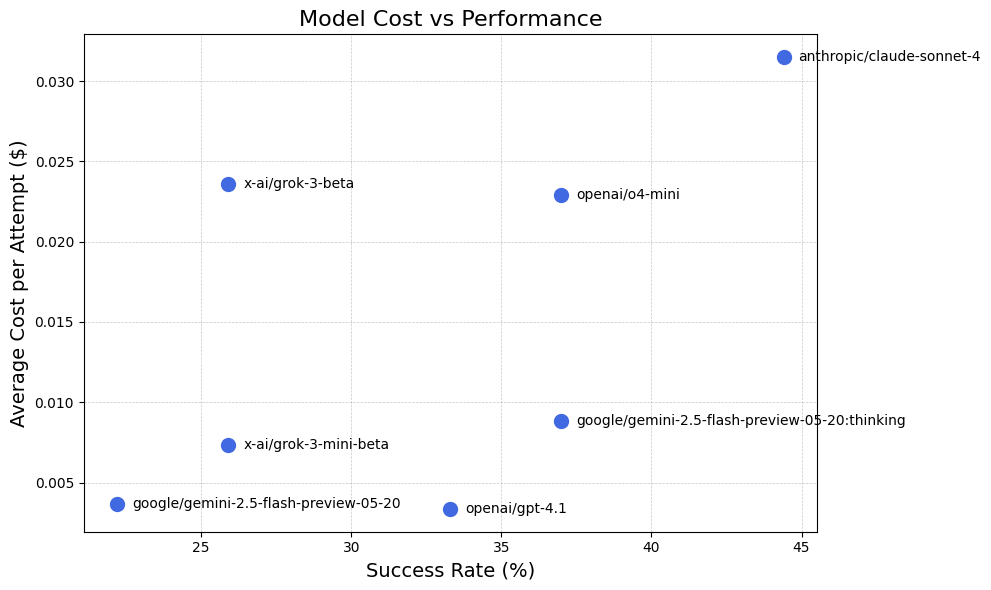

In [268]:
# Merge success rate and cost dataframes
merged_df = agg_success_rate[['model', 'success_rate']].merge(
    cost_per_attempt[['model', 'avg cost per attempt ($)']],
    on='model'
)

# Prepare x and y (no jitter)
x_values = merged_df['success_rate']
y_values = merged_df['avg cost per attempt ($)']

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, s=100, color='royalblue')

# Add model labels next to points
for i, row in merged_df.iterrows():
    plt.text(
        x_values.iloc[i] + 0.5,  # small offset to right
        y_values.iloc[i],
        row['model'],
        fontsize=10,
        va='center'
    )

# Labels and title
plt.xlabel('Success Rate (%)', fontsize=14)
plt.ylabel('Average Cost per Attempt ($)', fontsize=14)
plt.title('Model Cost vs Performance', fontsize=16)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('visualization/cost_vs_performance.pdf', bbox_inches='tight')
plt.show()


### (WIP) Success rates with different prompt lengths

In [10]:
# Success rate per model compared across a few levels of tutorial verbosity
df['tutorial_len'] = df['tutorial'].apply(lambda x: len(x) if isinstance(x, str) else 0)

tutorial_success = df.groupby(['model', 'tutorial_len'])['success'].mean().reset_index()
tutorial_success['success'] = (tutorial_success['success'] * 100).round(2)
tutorial_success.rename(columns={'success': 'Success Rate (%)', 'tutorial_len': 'Tutorial Length'}, inplace=True)

tutorial_success

,model,Tutorial Length,Success Rate (%)
0,anthropic/claude-sonnet-4,8665,6.49
1,google/gemini-2.5-flash-preview-05-20,8665,0.55
2,google/gemini-2.5-flash-preview-05-20:thinking,8665,3.26
3,openai/gpt-4.1,8665,0.94
4,openai/o4-mini,8665,5.03
5,x-ai/grok-3-beta,8665,3.11
6,x-ai/grok-3-mini-beta,8665,2.19


### (WIP) Success rates with different tutorial lengths

In [84]:
# Success rate per model compared across a few levels of prompt verbosity
df['prompt_len'] = df['prompt'].apply(lambda x: len(x) if isinstance(x, str) else 0)

prompt_success = df.groupby(['model', 'prompt_len'])['success'].mean().reset_index()
prompt_success['success'] = (prompt_success['success'] * 100).round(2)
prompt_success.rename(columns={'success': 'Success Rate (%)', 'prompt_len': 'Prompt Length'}, inplace=True)

prompt_success

,model,Prompt Length,Success Rate (%)
0,anthropic/claude-3.7-sonnet:thinking,1422,0.00
1,anthropic/claude-sonnet-4,1422,13.64
2,deepseek/deepseek-chat-v3-0324,1422,0.00
3,deepseek/deepseek-r1-0528,1422,0.00
4,google/gemini-2.5-flash-preview-05-20,1422,0.66
5,google/gemini-2.5-flash-preview-05-20:thinking,1422,6.90
6,openai/gpt-4.1,1422,0.65
7,openai/o3-mini,1422,0.00
8,openai/o4-mini,1422,5.26
9,x-ai/grok-3-mini-beta,1422,4.76


### Aggregate pass@k metrics for each model

In [215]:
# List of (full_run_id, model, exercise, sorted list of success flags per attempt)
run_attempts = df.sort_values(['full_run_id', 'attempt']).groupby('full_run_id').agg({
    'model': 'first',
    'exercise': 'first',
    'success': lambda x: list(x),  # get list of success flags
    'attempt': 'max'  # store max_attempts per run (for correct "not used k" logic)
}).reset_index()

# Determine global max k (max number of attempts used in any run)
max_k = df['max_attempts'].max()

# Compute pass@k columns
for k in range(1, max_k + 1):
    def pass_at_k(row):
        success_flags = row['success']
        used_attempts = len(success_flags)
        success_in_k = any(success_flags[:k])
        not_used_k = used_attempts < k
        return success_in_k #or not_used_k
    
    run_attempts[f'pass@{k}'] = run_attempts.apply(pass_at_k, axis=1)

# Now compute per-model pass@k mean
passk_cols = [f'pass@{k}' for k in range(1, max_k + 1)]
passk_summary = run_attempts.groupby('model')[passk_cols].mean().reset_index()

# Convert to % and round
for col in passk_cols:
    passk_summary[col] = (passk_summary[col] * 100).round(2)

# Optional: rename columns to Pass@k (%) style
passk_summary.rename(columns={col: f'Pass@{col.split("@")[1]} (%)' for col in passk_cols}, inplace=True)

# Display
passk_summary


,model,Pass@1 (%),Pass@2 (%),Pass@3 (%),Pass@4 (%),Pass@5 (%),Pass@6 (%),Pass@7 (%),Pass@8 (%),Pass@9 (%),...,Pass@41 (%),Pass@42 (%),Pass@43 (%),Pass@44 (%),Pass@45 (%),Pass@46 (%),Pass@47 (%),Pass@48 (%),Pass@49 (%),Pass@50 (%)
0,anthropic/claude-sonnet-4,11.11,33.33,33.33,37.04,37.04,37.04,40.74,40.74,44.44,...,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44
1,google/gemini-2.5-flash-preview-05-20,14.81,18.52,18.52,18.52,18.52,18.52,18.52,18.52,18.52,...,22.22,22.22,22.22,22.22,22.22,22.22,22.22,22.22,22.22,22.22
2,google/gemini-2.5-flash-preview-05-20:thinking,14.81,18.52,25.93,25.93,25.93,33.33,33.33,37.04,37.04,...,37.04,37.04,37.04,37.04,37.04,37.04,37.04,37.04,37.04,37.04
3,openai/gpt-4.1,11.11,11.11,18.52,18.52,22.22,22.22,22.22,22.22,22.22,...,33.33,33.33,33.33,33.33,33.33,33.33,33.33,33.33,33.33,33.33
4,openai/o4-mini,7.41,18.52,22.22,22.22,29.63,29.63,33.33,37.04,37.04,...,37.04,37.04,37.04,37.04,37.04,37.04,37.04,37.04,37.04,37.04
5,x-ai/grok-3-beta,7.41,11.11,18.52,18.52,22.22,22.22,22.22,22.22,22.22,...,25.93,25.93,25.93,25.93,25.93,25.93,25.93,25.93,25.93,25.93
6,x-ai/grok-3-mini-beta,14.81,14.81,14.81,18.52,22.22,22.22,22.22,22.22,22.22,...,25.93,25.93,25.93,25.93,25.93,25.93,25.93,25.93,25.93,25.93


### Pass@k plot

In [245]:
import matplotlib.pyplot as plt
import numpy as np

def plot_passk_summary(passk_summary, run_attempts, k_default_plot=10, show_last_marker=True):
    """
    Plot Pass@k CDF curves per model.
    - If a model used <= k_default_plot attempts, plot up to k_default_plot.
    - If a model used > k_default_plot attempts, plot up to its full max_attempts.
    - Optionally show marker on last point only.
    
    Args:
        passk_summary: DataFrame with Pass@k (%) columns (like your screenshot)
        run_attempts: DataFrame with per-run info, must include columns ['model', 'attempt']
        k_default_plot: int, default cutoff for low-attempt models (default 10)
        show_last_marker: bool, whether to show a dot on the last point of each line
    """
    # Determine max_attempts per model from run_attempts
    max_attempts_per_model = run_attempts.groupby('model')['attempt'].max().to_dict()

    # Optional: define line styles for variety
    line_styles = ['-', '--', '-.', ':']

    # Plot
    plt.figure(figsize=(12, 8))

    for i, (_, row) in enumerate(passk_summary.iterrows()):
        model_name = row['model']
        model_max_k = max_attempts_per_model.get(model_name, 50)  # fallback to 50 if missing
        
        # Determine which k to plot
        if model_max_k <= k_default_plot:
            k_plot = list(range(1, k_default_plot + 1))
        else:
            k_plot = list(range(1, model_max_k + 1))

        # Extract y values safely
        y = [row.get(f'Pass@{k} (%)', None) for k in k_plot]

        # Choose line style
        #linestyle = line_styles[(i + 2) % len(line_styles)]
        linestyle = line_styles[0]

        # Define per-model horizontal offset (small, e.g. ±0.1 or ±0.2)
        # Example: deterministic offset based on model index
        horizontal_offsets = np.linspace(-0.3, 0.3, len(passk_summary))  # spread nicely

        # Inside loop:
        offset = horizontal_offsets[i]  # pick offset for this model

        # Apply offset to x values
        x_shifted = np.array(k_plot) + offset

        # Now plot using x_shifted instead of k_plot
        plt.plot(x_shifted, y, linestyle=linestyle, linewidth=2, label=model_name)

        # Optional: marker on last point → shifted too
        if show_last_marker:
            plt.plot(x_shifted[-1], y[-1], marker='o', markersize=6)


    # Labels and title
    plt.xlabel('k (Number of attempts)', fontsize=14)
    plt.ylabel('Pass@k (%)', fontsize=14)
    plt.title(f'Pass@k Cumulative Success per Model', fontsize=16)
    
    # Legend in bottom right
    plt.legend(title='Model', fontsize=12, loc='lower right')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig('visualization/pass_at_k.pdf', bbox_inches='tight')
    plt.show()


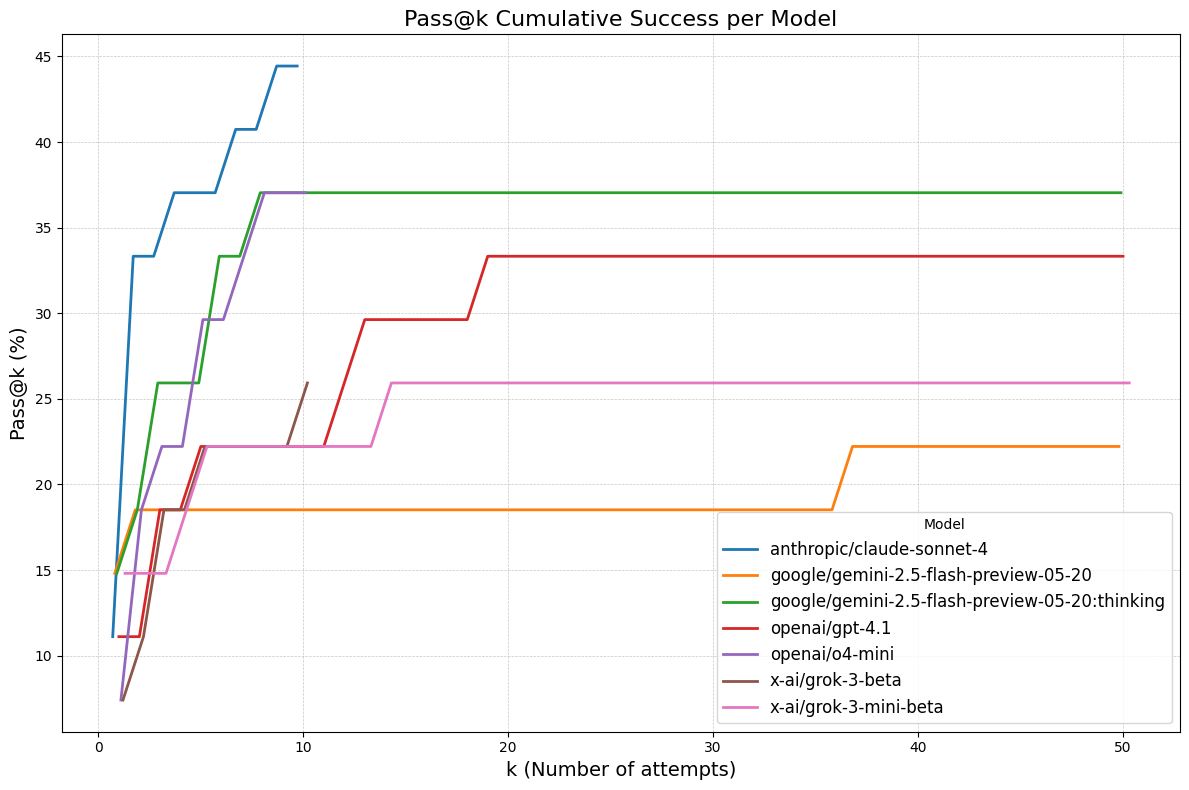

In [246]:
plot_passk_summary(passk_summary, run_attempts, k_default_plot=10, show_last_marker=False)


# TODOs

In [24]:
# TODO:
# thinking vs no thinking models (all)
# thinking vs no thinking on models that support both (fair)
# definition expanding comparison